In [31]:
#!pip install stop-words
#!pip install wordcloud
!pip install Pillow

In [32]:
%matplotlib inline
#Dependencies
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [33]:
#target search
target_elon = ("@elonmusk")

#counter
counter = 1

#variable for holding sentiments
sentiments = []

#Loop through all tweets
for target in target_elon:
   
    #Variable for oldest tweet
    oldest_tweet = None
    
    #Loop through 5 pages from home feed (total 100 tweets)
    for x in range (5):
        
        #Get all tweets from home feed
        public_tweets = api.user_timeline(target_elon, max_id = oldest_tweet)
        
        #loop through all tweets
        for tweet in public_tweets:
            
            #Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results ["compound"]
            pos = results ["pos"]
            neg = results ["neg"]
            neu = results ["neu"]
            
            #Get oldest tweet id, subtract 1, and assign to oldest tweet
            oldest_tweet = tweet["id"] - 1
            
            #Add sentiments for each tweet into a list
            sentiments.append({"Source":target_elon,
                              "Text":tweet["text"],
                              "Date":tweet["created_at"],
                              "Compound":compound,
                              "Positive":pos,
                              "Neutral":neu,
                              "Negative":neg,
                              "Retweeted?":tweet["retweeted"],
                              "Retweet Count":tweet["retweet_count"],
                              "Favorite Count": tweet["favorite_count"]})
            counter +=1
tweets_df = pd.DataFrame.from_dict(sentiments)
tweets_df.head()
        

,Compound,Date,Favorite Count,Negative,Neutral,Positive,Retweet Count,Retweeted?,Source,Text
0,0.0000,Thu Nov 01 21:19:44 +0000 2018,6867,0.000,1.000,0.000,344,False,@elonmusk,@TeslaMotorsClub ♥️ Norway 🇳🇴
1,0.4215,Thu Nov 01 21:14:38 +0000 2018,0,0.000,0.853,0.147,504,False,@elonmusk,RT @Pogue: My exclusive test drive: A software...
2,-0.2617,Thu Nov 01 19:35:57 +0000 2018,4232,0.093,0.907,0.000,236,False,@elonmusk,"@InsideEVs @Tesla #’s r wrong, but 🐻 in 🧠 Tesl..."
3,0.4569,Thu Nov 01 10:55:25 +0000 2018,613,0.000,0.819,0.181,35,False,@elonmusk,"@vaipier Long-term, the car will work purely o..."
4,0.0000,Thu Nov 01 10:48:25 +0000 2018,1071,0.000,1.000,0.000,44,False,@elonmusk,@GlamandGore https://t.co/l8kmDOLJkZ


In [34]:
#Remove retweets and change the order of columns
tweets_df = tweets_df[tweets_df["Retweeted?"]==False][["Source","Text","Date","Compound","Positive","Neutral","Negative","Retweet Count","Favorite Count"]]
tweets_df.head()

,Source,Text,Date,Compound,Positive,Neutral,Negative,Retweet Count,Favorite Count
0,@elonmusk,@TeslaMotorsClub ♥️ Norway 🇳🇴,Thu Nov 01 21:19:44 +0000 2018,0.0000,0.000,1.000,0.000,344,6867
1,@elonmusk,RT @Pogue: My exclusive test drive: A software...,Thu Nov 01 21:14:38 +0000 2018,0.4215,0.147,0.853,0.000,504,0
2,@elonmusk,"@InsideEVs @Tesla #’s r wrong, but 🐻 in 🧠 Tesl...",Thu Nov 01 19:35:57 +0000 2018,-0.2617,0.000,0.907,0.093,236,4232
3,@elonmusk,"@vaipier Long-term, the car will work purely o...",Thu Nov 01 10:55:25 +0000 2018,0.4569,0.181,0.819,0.000,35,613
4,@elonmusk,@GlamandGore https://t.co/l8kmDOLJkZ,Thu Nov 01 10:48:25 +0000 2018,0.0000,0.000,1.000,0.000,44,1071


In [35]:
#convert to date format and extract hour
#from datetime import datetime
#from datetime_z import parse_datetime
#date_format = "%Y-%m-%dT%H:%M:%S"
#date_format = "%a%b%m%X%z%Y"
#tweets_df["Date"]= pd.to_datetime(tweets_df["Date"],format = date_format)
#tweets_df["Hour"]= pd.DateTimeIndex(tweets_df[Date]).hour

#create new tweets column
tweets_df["Tweets"]= tweets_df["Text"]

#Text Manipulation
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

#function to remove special characters, punctuations, stop words, digits, hyperlinks, etc.
def string_manipulation(df,column):
    #extract hastags
    df["Hashtag"] = df[column].str.findall(r'#.*?(?=\s|$)')
    #extract twitter account references
    df["Accounts"] = df[column].str.findall(r'@.*?(?=\s|$)')
    
    #remove hashtags and accounts from tweets
    df[column] = df[column].str.replace(r'#.*?(?=\s|$)'," ")
    df[column] = df[column].str.replace(r'@.*?(?=\s|$)'," ")
    
    #convert to lower case
    df[column] = df[column].str.lower()
    #remove hyperlinks
    df[column] = df[column].apply(lambda x:re.split('https:\/\/.*',str(x))[0])
    #remove punctuations
    df[column] = df[column].str.replace('[^\w\s]'," ")
    #remove special characters
    df[column] = df[column].str.replace("\W"," ")
    #remove digits
    df[column] = df[column].str.replace("\d+"," ")
    #remove under scores
    df[column] = df[column].str.replace("-"," ")
    #remove stopwords
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split()
                                                     if i not in (stop_words)]))
    return df

tweets_df = string_manipulation(tweets_df,"Text")
tweets_df.head()

,Source,Text,Date,Compound,Positive,Neutral,Negative,Retweet Count,Favorite Count,Tweets,Hashtag,Accounts
0,@elonmusk,norway,Thu Nov 01 21:19:44 +0000 2018,0.0000,0.000,1.000,0.000,344,6867,@TeslaMotorsClub ♥️ Norway 🇳🇴,[],[@TeslaMotorsClub]
1,@elonmusk,rt exclusive test drive software update gives ...,Thu Nov 01 21:14:38 +0000 2018,0.4215,0.147,0.853,0.000,504,0,RT @Pogue: My exclusive test drive: A software...,[],[@Pogue:]
2,@elonmusk,r wrong tesla makes overseas amp east coast st...,Thu Nov 01 19:35:57 +0000 2018,-0.2617,0.000,0.907,0.093,236,4232,"@InsideEVs @Tesla #’s r wrong, but 🐻 in 🧠 Tesl...",[#’s],"[@InsideEVs, @Tesla]"
3,@elonmusk,long term car work purely vision radar plus ma...,Thu Nov 01 10:55:25 +0000 2018,0.4569,0.181,0.819,0.000,35,613,"@vaipier Long-term, the car will work purely o...",[],[@vaipier]
4,@elonmusk,,Thu Nov 01 10:48:25 +0000 2018,0.0000,0.000,1.000,0.000,44,1071,@GlamandGore https://t.co/l8kmDOLJkZ,[],[@GlamandGore]


In [36]:
from PIL import Image
from os import path
twitter_mask = np.array(Image.open("images/twitter.png"))
twitter_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [37]:
def transform_format(val):
    if val ==0:
        return 255
    else:
        return val

In [38]:
transformed_twitter = np.ndarray((twitter_mask.shape[0],twitter_mask.shape[1]),np.int32)
for i in range(len(twitter_mask)):
    transformed_twitter[i]=list(map(transform_format,twitter_mask[i]))

In [39]:
transformed_twitter

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

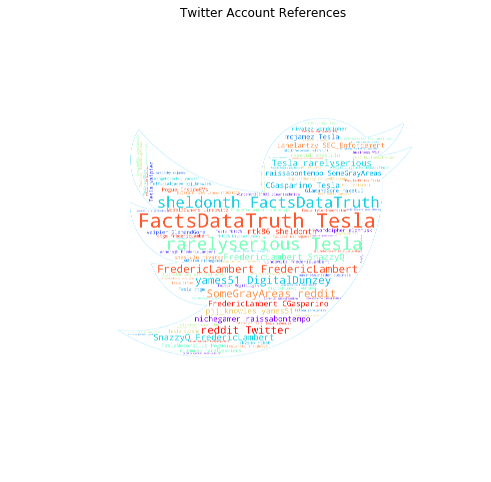

In [40]:
from wordcloud import WordCloud, ImageColorGenerator


acc_wrds = tweets_df["Tweets"].str.extractall(r'(\@\w+)')[0]
def build_word_cloud(words,back_color,palette,title):
    word_cloud = WordCloud(scale = 7, max_words=1000, max_font_size = 100,background_color = "white", random_state = 0, colormap = palette, mask=transformed_twitter,contour_width=4,contour_color="deepskyblue").generate(" ".join(words))
    plt.figure(figsize = (13,8))
    plt.imshow(word_cloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
build_word_cloud(acc_wrds,"black","rainbow","Twitter Account References")

In [41]:
positive_words = pd.read_csv("positive.txt",header=None)
negative_words = pd.read_csv("negative.txt", header=None, encoding='latin-1')

#convert words to lists
def convert_words_list(df):
    words = string_manipulation(df,0)
    words_list = words[words[0] != ""][0].tolist()
    return words_list

positive_words_list = convert_words_list(positive_words)
negative_words_list = convert_words_list(negative_words)

print("Positive Words: ")
print(positive_words_list[:20])
print("Negative Words: ")
print(negative_words_list[:20])

Positive Words: 
['suggestive', 'staple', 'shy', 'overhead', 'momentary', 'piety', 'spur', 'beaver', 'reinforcement', 'toss', 'devour', 'evaluation', 'knockout', 'ajar', 'ingest', 'brazen', 'squishy', 'dry', 'composite', 'customary']
Negative Words: 
['murder', 'leukemia', 'rapist', 'torture', 'torture', 'wreck', 'abuse', 'mourning', 'gonorrhea', 'abuse', 'rape', 'herpes', 'unsanitary', 'murder', 'wreck', 'rape', 'molester', 'disease', 'lynching', 'motherfucker']


In [43]:
#Scoring tweets based on positive and negative words count
def scoring_tweets(data_frame,text_column):
    data_frame["positive"] = data_frame[text_column].apply(lambda x:" ".join([i for i in x.split() 
                                                                              if i in (positive_words_list)]))
    data_frame["negative"] = data_frame[text_column].apply(lambda x:" ".join([i for i in x.split()
                                                                              if i in (negative_words_list)]))
    #scoring
    data_frame["positive_count"] = data_frame["positive"].str.split().str.len()
    data_frame["negative_count"] = data_frame["negative"].str.split().str.len()
    data_frame["score"]    = data_frame["positive_count"] - data_frame["negative_count"]
    
    #create new feature sentiment :
    #+ve if score is +ve , #-ve if score is -ve , # neutral if score is 0
    def labeling(data_frame) :
        if data_frame["score"]   > 0  :
            return "positive"
        elif data_frame["score"] < 0  :
            return "negative"
        elif data_frame["score"] == 0 :
            return "neutral"
    data_frame["sentiment"] = data_frame.apply(lambda data_frame:labeling(data_frame),
                                               axis = 1)
        
    return data_frame

#print(scoring_tweets)
tweets_df  =  scoring_tweets(tweets_df,"Text")
tweets_df[["Text","positive","negative","positive_count",
              "negative_count","score","sentiment"]]

,Text,positive,negative,positive_count,negative_count,score,sentiment
0,norway,,,0,0,0,neutral
1,rt exclusive test drive software update gives ...,drive ability pass slow get shift,exclusive test pass slow get shift,6,6,0,neutral
2,r wrong tesla makes overseas amp east coast st...,amp quarter,wrong half,2,2,0,neutral
3,long term car work purely vision radar plus ma...,work vision plus worth,long work,4,2,2,positive
4,,,,0,0,0,neutral
5,make work far away los safety,make work far away safety,work far away,5,3,2,positive
6,hahaha lt ahem gt,,,0,0,0,neutral
7,um yes,yes,,1,0,1,positive
8,maybe ai make follow laugh like demon amp say pet,make follow laugh like amp say pet,follow demon,7,2,5,positive
9,also able drive phone remotely like big rc car...,able drive remotely like big sight,line sight,6,2,4,positive


In [ ]:
#var apiKey= "zskyLKm-iUFzeiivWVKG"

In [ ]:
#https://www.quandl.com/api/v3/datasets/OPEC/ORB.csv?api_key=YOUR_API_KEY_HERE